In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy.optimize as sciopt
import scipy.stats as stats
import pandas as pd

data = pd.read_csv('../results/dose_response_params_09252023.csv')
g_drugless = data['g_drugless']
ic50_est = data['ic50']
mut_list = data['n_mut']

gr_lib = pd.read_csv('../results/gr_lib.csv',index_col=0)
gr_err_lib = pd.read_csv('../results/gr_err_lib.csv',index_col=0)

def int_to_binary(num,n_genotype=16):
    """
    Converts an integer to binary representation with the number of 
    digits equal to the number of alleles in the model.

    Parameters
    ----------
    num : int
        Number to be converted.

    Returns
    -------
    str
        Binary representation.

    """
    pad = int(np.log2(n_genotype))
    return bin(num)[2:].zfill(pad)

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_20236/1771774967.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma',6)


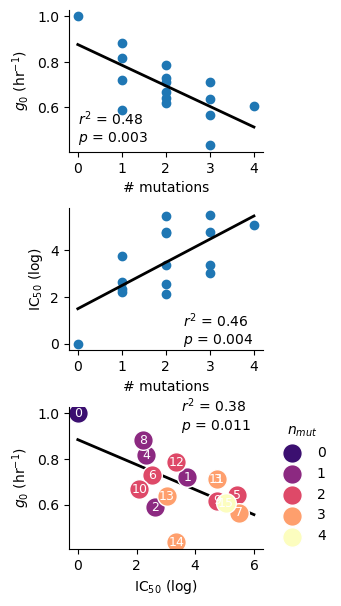

In [54]:
data = pd.read_csv('../results/dose_response_params_09252023.csv')
g_drugless = data['g_drugless']
ic50_est = data['ic50']
mut_list = data['n_mut']

label_size = 10

fig,ax_list = plt.subplots(nrows=3,figsize=(2.5,7))

g_drugless = np.array(g_drugless)
g_norm = g_drugless/g_drugless[0]

ax = ax_list[0]

ax.plot(mut_list,g_norm,'o')

res = stats.linregress(mut_list,g_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='k',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=label_size)
ax.set_ylabel('$g_{0}$ (hr$^{-1}$)',fontsize=label_size)
ax.tick_params(axis='both', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(0,0.45),fontsize=10)

ax = ax_list[1]

ic50_norm = ic50_est - ic50_est[0]

ax.plot(mut_list,ic50_norm,'o')

res = stats.linregress(mut_list,ic50_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='k',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=label_size)
ax.set_ylabel('IC$_{50}$ (log)',fontsize=label_size)
ax.tick_params(axis='both', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(2.4,0),fontsize=10)

ax = ax_list[2]

cmap = cm.get_cmap('magma',6)
cmap = cmap.colors

mut_v_gr = [[],[],[],[],[]]

ic50_norm = ic50_est - ic50_est[0]

for key in data.index:

    ic50 = ic50_norm[int(key)]
    g = g_norm[int(key)]

    # key_bin = int(key)

    num = mut_list[int(key)]

    mut_v_gr[num].append(g_drugless)

    ax.scatter(ic50,g,marker='o',s=200,facecolor=cmap[num+1],
                edgecolors='w',label=int(num))
    ax.annotate(key,(ic50,g),fontsize=9,ha='center',va='center',color='white')
    # ax4.annotate(key,(ic50-0.15,g_drugless-0.001),fontsize=12)
    # ax.annotate(key,(ic50,g),fontsize=9,ha='center',va='center',color='gainsboro')
    

# ax.set_ylim(0.06,0.115)
# ax.set_xlim(-3,4)
# ax.set_ylabel('Drug-free growth rate ($hr^{-1}$)',fontsize=12)
ax.set_ylabel('$g_{0}$ (hr$^{-1}$)',fontsize=label_size)
ax.set_xlabel('IC$_{50}$ (log)',fontsize=label_size)
ax.tick_params(axis='both', labelsize=10)

handles, labels = ax.get_legend_handles_labels()

unique_labels = sorted(set(labels))
labels = np.array(labels)
unique_handles = []

for lab in unique_labels:
    indx = np.argwhere(labels==lab)
    indx = indx[0][0]
    unique_handles.append(handles[indx])

ax.legend(unique_handles,unique_labels,loc = (1.05,0),frameon=False,
             fontsize=10,title='$n_{mut}$')

res = stats.linregress(ic50_norm,g_norm)

xfit = np.arange(0,7)
yfit = res.slope*xfit + res.intercept

ax.plot(xfit,yfit,color='k',linewidth=2,zorder=0)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(3.5,0.93),fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.subplots_adjust(hspace=0.4)

fig.savefig('../figures/gr_vs_ic50_regression.pdf',bbox_inches='tight')
fig.savefig('../figures/gr_vs_ic50_regression.png',bbox_inches='tight',dpi=300)

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_20236/3445723673.py:8: RuntimeWarning: overflow encountered in exp
  y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))


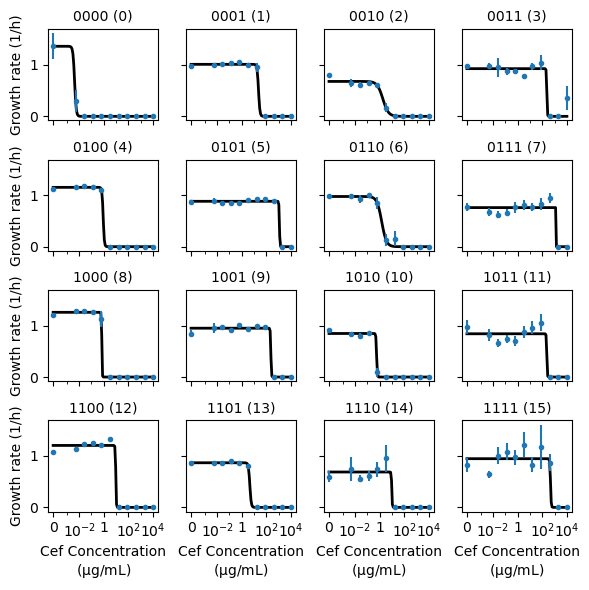

In [3]:
def hill_fn(conc,gmax, hc, ic_50):
    y = []
    gmin = 0
    for c in conc:
        if c == 0:
            y.append(gmax)
        else:
            y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))
    return y

fig,ax_list = plt.subplots(nrows=4,ncols=4,figsize=(6,6),sharex=True,sharey=True)
ax_list_matrix = ax_list
ax_list = ax_list.flatten()

g_drugless = np.zeros(16)

mic_est = []

seascape_lib = {}

# drug_conc = np.array(gr_lib['drug_conc'])
drug_conc = list(gr_lib['drug_conc'])
drug_conc = [float(i) for i in drug_conc if i != 'control']

for key in np.arange(16):
    y = np.array(gr_lib[str(key)])
    y = y[0:-1]
    x = np.argwhere(y<0.5)
    mic = drug_conc[x[-1][0]]
    mic_est.append(mic)

for i in range(16):
    
    gr_v_dc = np.array(gr_lib[str(i)])
    gr_v_dc_err = np.array(gr_err_lib[str(i)])

    ic50_est = np.log10(np.array(mic_est[i]).astype(float))

    p0 = [gr_v_dc[-2],-0.1,ic50_est]
    # bounds = [[gr_v_dc[-2]-0.1,-10,ic50_est-2],[gr_v_dc[-2]+0.1,0,ic50_est+2]]
    bounds = [[0,-10,ic50_est-2],[2,0,ic50_est+2]]

    gr_v_dc_err_t = np.array(gr_v_dc_err) + 1

    popt,pcov = sciopt.curve_fit(hill_fn,drug_conc,gr_v_dc[0:-1],
                                p0=p0,maxfev=100000,bounds=bounds,
                                sigma=gr_v_dc_err_t[0:-1],absolute_sigma=False)
    
    xfit = np.logspace(-3,4,100)
    xfit = np.concatenate(([0],xfit))

    yfit = hill_fn(xfit,*popt)

    ax = ax_list[i]
    ax.plot(xfit,yfit,color='k',linewidth=2)

    ax.errorbar(drug_conc,gr_v_dc[0:-1],yerr=gr_v_dc_err[0:-1],
                fmt='o',markersize=3)
    
    ax.set_xscale('symlog',linthresh=10**-3)
    ax.set_title(int_to_binary(i) + ' (' + str(i) + ')',fontsize=10)
    # ax.set_yscale('log')
    g_drugless[i] = gr_v_dc[-2]

    param_dict = {'gmax':popt[0],'hc':popt[1],'ic50':popt[2]}
    seascape_lib[i] = param_dict

# ax = ax_list[-1]
# ax.set_xticks([0,10**-2,1,10**2,10**4]);
# ax.set_xticklabels(['0','10$^{-2}$','1','10$^{2}$','10$^{4}$'],fontsize=8)
for ax in ax_list_matrix[-1,:]:
    ax.set_xticks([0,10**-2,1,10**2,10**4]);
    ax.set_xticklabels(['0','10$^{-2}$','1','10$^{2}$','10$^{4}$'],fontsize=10)

for ax in ax_list_matrix[-1,:]:
    ax.set_xlabel('Cef Concentration\n' + r'($\mathrm{\mu}$g/mL)')

for ax in ax_list_matrix[:,0]:
    ax.set_ylabel('Growth rate (1/h)')

# ax_list_matrix[0,0].annotate('A',(-0.1,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()

fig.savefig('../figures/dose_response_curves.pdf',bbox_inches='tight')

In [4]:
for key in seascape_lib.keys():
    
    print(seascape_lib[key]['gmax'])

1.3627516148594752
1.0116273984763136
0.6792185317268813
0.9276039604874466
1.1542428009192853
0.8828861252972288
0.9762377496690174
0.7604102428712447
1.2589608057473558
0.949952405731921
0.8469659806963428
0.8413912921597473
1.2049050837489887
0.8677695037090773
0.6880990889576407
0.9470095681293055


In [5]:
def gen_neighbors(genotype,n_allele=4):
    mut = range(n_allele)
    neighbors = [genotype ^ (1 << m) for m in mut]

    return neighbors

diff_dict = {}
diff_dict_rel = {} # relative to the wt

ic50_diff_dict = {}

for allele in [0,1,2,3]:
    # generate each genotype contaiing the allele
    contains_allele = []
    excludes_allele = []
    for i in range(16):
        if int_to_binary(i)[3-allele] == '1':
            contains_allele.append(i)
        else:
            excludes_allele.append(i)
    
    diff = []
    ic50_diff = []
    for g in contains_allele:
        neighbors = gen_neighbors(g)
        # find the neighbors that do not contain the allele
        neighbors = [n for n in neighbors if n in excludes_allele]

        cur_fit = g_drugless[g]
        cur_ic50 = ic50_norm[g]

        neighbor_fit = g_drugless[neighbors[0]]
        neighbor_ic50 = ic50_norm[neighbors[0]]

        diff.append(cur_fit - neighbor_fit)
        ic50_diff.append(cur_ic50 - neighbor_ic50)

    diff_dict[allele] = diff
    diff_dict_rel[allele] = [g_drugless[i]-g_drugless[0] for i in contains_allele]
    ic50_diff_dict[allele] = ic50_diff
    

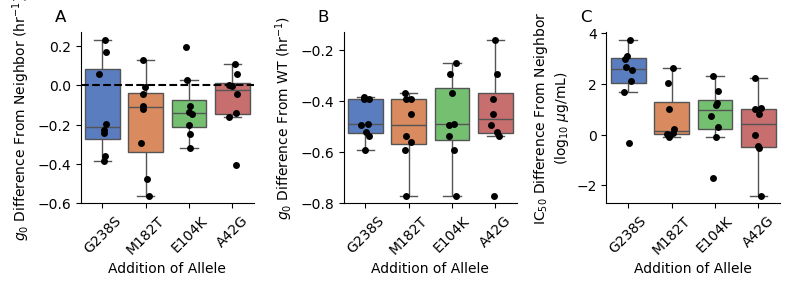

In [6]:
import seaborn as sns

fig,ax_list = plt.subplots(ncols=3,figsize=(8,3))

ax = ax_list[0]
sns.boxplot(data=pd.DataFrame(diff_dict),ax=ax,showfliers=False,palette='muted')
sns.stripplot(data=pd.DataFrame(diff_dict),ax=ax,color='k',size=5)

ax.set_ylabel('$g_{0}$ Difference From Neighbor (hr$^{-1}$)')
ax.set_xlabel('Addition of Allele')

ax.plot([-1,4],[0,0],'k--')

ax.set_xlim(-0.5,3.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = ax_list[1]

sns.boxplot(data=pd.DataFrame(diff_dict_rel),ax=ax,showfliers=False,palette='muted')
sns.stripplot(data=pd.DataFrame(diff_dict_rel),ax=ax,color='k',size=5)

ax.set_ylabel('$g_{0}$ Difference From WT (hr$^{-1}$)')
ax.set_xlabel('Addition of Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = ax_list[2]

sns.boxplot(data=pd.DataFrame(ic50_diff_dict),ax=ax,showfliers=False,palette='muted')
sns.stripplot(data=pd.DataFrame(ic50_diff_dict),ax=ax,color='k',size=5)

ax.set_ylabel('IC$_{50}$ Difference From Neighbor \n(log$_{10}$ $\mu$g/mL)')
ax.set_xlabel('Addition of Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for ax in ax_list:
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['G238S','M182T','E104K','A42G'],rotation=45)

labels = ['A','B','C']
for i,ax in enumerate(ax_list):
    ax.annotate(labels[i],(-0.15,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()

# make sure the right axis is the same width as the left
pos = ax_list[0].get_position()
pos2 = ax_list[2].get_position()
width = pos.width
pos2.x1 = pos2.x0 + width
ax_list[2].set_position(pos2)


fig.savefig('../figures/allele_fitness_diff.pdf',bbox_inches='tight')

In [7]:
# pairwise t-test for ic50 differences

for i in range(4):
    for j in range(i+1,4):
        print('Allele',i,'vs Allele',j)
        pval = stats.ttest_ind(ic50_diff_dict[i],ic50_diff_dict[j],equal_var=False).pvalue
        print('p-value:',pval)

Allele 0 vs Allele 1
p-value: 0.015956257208206405
Allele 0 vs Allele 2
p-value: 0.021488719661020797
Allele 0 vs Allele 3
p-value: 0.006632404297456379
Allele 1 vs Allele 2
p-value: 0.9718289869531536
Allele 1 vs Allele 3
p-value: 0.4151498153155072
Allele 2 vs Allele 3
p-value: 0.4611923395005765


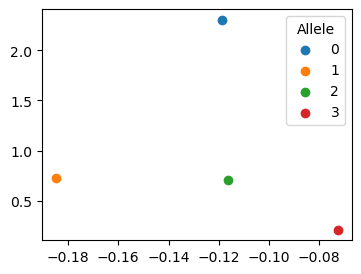

In [8]:
fig,ax = plt.subplots(figsize=(4,3))

for key in diff_dict.keys():

    diff = np.mean(diff_dict[key])
    ic_50 = np.mean(ic50_diff_dict[key])


    ax.scatter(diff,ic_50,label=key)

ax.legend(title='Allele',fontsize=10)

In [9]:
import statsmodels.api as sm

data = pd.DataFrame(columns=['g0','ic50','G238S','M182T','E104K','A42G'])

for i in range(16):
    data.loc[i] = [g_drugless[i],ic50_norm[i],0,0,0,0]
    for j in range(4):
        if int_to_binary(i)[3-j] == '1':
            data.loc[i][j+2] = 1

formula = 'g0 ~ G238S + M182T + E104K + A42G + G238S:M182T + G238S:E104K + G238S:A42G + M182T:E104K + M182T:A42G + E104K:A42G'

model = sm.OLS.from_formula(formula,data=data)

result_gr = model.fit()

print(result_gr.summary())

formula = 'ic50 ~ G238S + M182T + E104K + A42G + G238S:M182T + G238S:E104K + G238S:A42G + M182T:E104K + M182T:A42G + E104K:A42G'

model = sm.OLS.from_formula(formula,data=data)

result_ic50 = model.fit()

print(result_ic50.summary())

                            OLS Regression Results                            
Dep. Variable:                     g0   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     2.168
Date:                Wed, 12 Jun 2024   Prob (F-statistic):              0.203
Time:                        16:59:37   Log-Likelihood:                 18.382
No. Observations:                  16   AIC:                            -14.76
Df Residuals:                       5   BIC:                            -6.266
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.3062      0.114     11.481      

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_20236/3300970680.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')


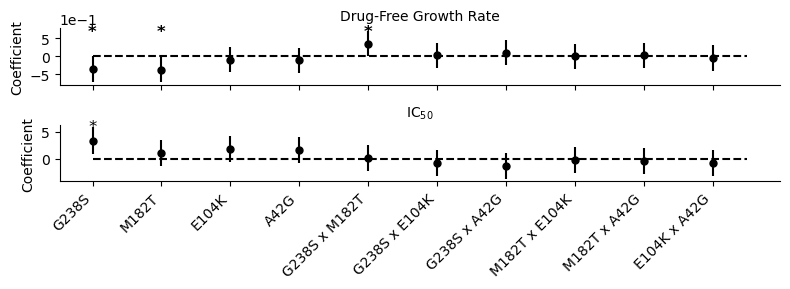

In [10]:
# fig,ax_list = plt.subplots(ncols=2,figsize=(6,4),sharey=True)
fig,ax_list = plt.subplots(nrows=2,figsize=(8,3),sharex=True)

# make a coefficient plot

coeffs = result_ic50.params[1:]
conf_int = result_ic50.conf_int(alpha=0.05)[1:]

ax = ax_list[1]

ax.errorbar(coeffs.index,coeffs,yerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
            fmt='o',color='k',markersize=5)

ax.set_ylabel('Coefficient')

# star the significant coefficients
for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        ax.annotate('*',xy=(i,6),fontsize=12,ha='center',va='center')

# ax.set_xlabel('Coefficient')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('IC$_{50}$',fontsize=10)

# ax.plot([0,0],[0,9.5],'k--')

ax = ax_list[0]

coeffs = result_gr.params[1:]
conf_int = result_gr.conf_int(alpha=0.05)[1:]

# ax.errorbar(coeffs,coeffs.index,xerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
#             fmt='o',color='k',markersize=5)
ax.errorbar(coeffs.index,coeffs,yerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
            fmt='o',color='k',markersize=5)

ax.set_ylabel('Coefficient')

# make y axis scientific notation
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        ax.annotate('*',xy=(i,0.7),fontsize=12,ha='center',va='center',fontweight='bold')

# ax.set_xlabel('Coefficient')
# ax.set_ylabel('Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Drug-Free Growth Rate',fontsize=10)

# ax.plot([0,0],[0,9.5],'k--')

# align ticklabels to the right

xl = ['E104K x A42G','M182T x A42G','M182T x E104K','G238S x A42G','G238S x E104K','G238S x M182T','A42G','E104K','M182T','G238S']
# reverse yl
xl = xl[::-1]
ax = ax_list[1]

ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')

# for x in xl:
#     x.set_horizontalalignment("right")
for ax in ax_list:
    ax.plot([0,9.5],[0,0],'k--')

# ax_list[0].annotate('D',(-0.05,1.06),fontsize=12,xycoords='axes fraction')
# ax_list[1].annotate('E',(-0.05,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()
fig.savefig('../figures/allele_mlr_coefficients.pdf',bbox_inches='tight')

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_20236/1336922758.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')
/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_20236/1336922758.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')


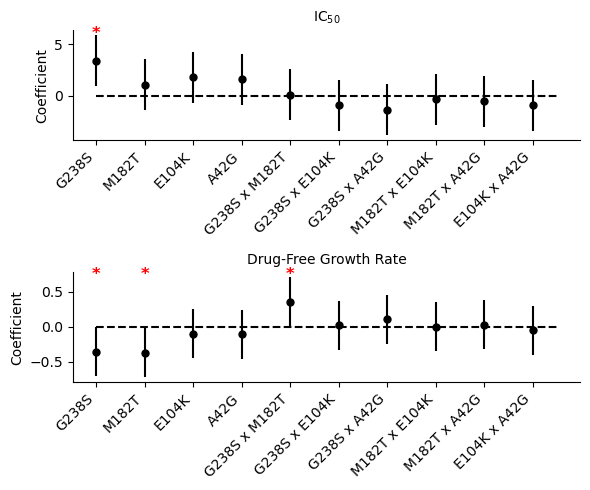

In [11]:
# fig,ax_list = plt.subplots(ncols=2,figsize=(6,4),sharey=True)
fig,ax_list = plt.subplots(nrows=2,figsize=(6,5))

# make a coefficient plot

coeffs = result_ic50.params[1:]
conf_int = result_ic50.conf_int(alpha=0.05)[1:]

ax = ax_list[0]

ax.errorbar(coeffs.index,coeffs,yerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
            fmt='o',color='k',markersize=5)

ax.set_ylabel('Coefficient')

# star the significant coefficients
for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        ax.annotate('*',xy=(i,6),fontsize=12,ha='center',va='center',
                    fontweight='bold',color='red')

# ax.set_xlabel('Coefficient')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('IC$_{50}$',fontsize=10)

# ax.plot([0,0],[0,9.5],'k--')

ax = ax_list[1]

coeffs = result_gr.params[1:]
conf_int = result_gr.conf_int(alpha=0.05)[1:]

# ax.errorbar(coeffs,coeffs.index,xerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
#             fmt='o',color='k',markersize=5)
ax.errorbar(coeffs.index,coeffs,yerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
            fmt='o',color='k',markersize=5)

ax.set_ylabel('Coefficient')

# make y axis scientific notation
# ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        ax.annotate('*',xy=(i,0.75),fontsize=12,ha='center',va='center',
                    fontweight='bold',color='red')

# ax.set_xlabel('Coefficient')
# ax.set_ylabel('Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Drug-Free Growth Rate',fontsize=10)

# ax.plot([0,0],[0,9.5],'k--')

# align ticklabels to the right

xl = ['E104K x A42G','M182T x A42G','M182T x E104K','G238S x A42G','G238S x E104K','G238S x M182T','A42G','E104K','M182T','G238S']
# reverse yl
xl = xl[::-1]
ax = ax_list[1]

ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')

ax = ax_list[0]
ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')

# for x in xl:
#     x.set_horizontalalignment("right")
for ax in ax_list:
    ax.plot([0,9.5],[0,0],'k--')

# ax_list[0].annotate('D',(-0.05,1.06),fontsize=12,xycoords='axes fraction')
# ax_list[1].annotate('E',(-0.05,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()
fig.savefig('../figures/allele_mlr_coefficients_tall.png',bbox_inches='tight',dpi=500)
fig.savefig('../figures/allele_mlr_coefficients_tall.pdf',bbox_inches='tight')

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_20236/4101895763.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xl, rotation=45, fontsize=10, ha='right')


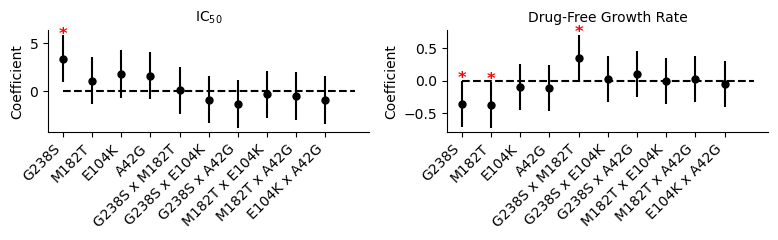

In [73]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, ax_list = plt.subplots(ncols=2, figsize=(8,2.5))

# Coefficient plot for IC50
coeffs = result_ic50.params[1:]
conf_int = result_ic50.conf_int(alpha=0.05)[1:]

ax = ax_list[0]
ax.errorbar(coeffs.index, coeffs, yerr=[coeffs - conf_int[0], conf_int[1] - coeffs],
            fmt='o', color='k', markersize=5)
ax.set_ylabel('Coefficient')

# Mark significant coefficients with a star
for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        star_offset = conf_int[1][i] - coeffs[i]
        ax.annotate('*', xy=(i, coeffs[i] + star_offset), fontsize=12, ha='center', va='center',
                    fontweight='bold', color='red')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('IC$_{50}$', fontsize=10)

# Coefficient plot for Drug-Free Growth Rate
coeffs = result_gr.params[1:]
conf_int = result_gr.conf_int(alpha=0.05)[1:]

ax = ax_list[1]
ax.errorbar(coeffs.index, coeffs, yerr=[coeffs - conf_int[0], conf_int[1] - coeffs],
            fmt='o', color='k', markersize=5)
ax.set_ylabel('Coefficient')

# Mark significant coefficients with a star
for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        star_offset = 1.1*(conf_int[1][i] - coeffs[i])
        ax.annotate('*', xy=(i, coeffs[i] + star_offset), fontsize=12, ha='center', va='center',
                    fontweight='bold', color='red')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Drug-Free Growth Rate', fontsize=10)

# Align x-axis labels and set rotation
xl = ['E104K x A42G', 'M182T x A42G', 'M182T x E104K', 'G238S x A42G', 'G238S x E104K', 
      'G238S x M182T', 'A42G', 'E104K', 'M182T', 'G238S']
xl = xl[::-1]

for ax in ax_list:
    ax.set_xticklabels(xl, rotation=45, fontsize=10, ha='right')
    ax.plot([0, len(coeffs)], [0, 0], 'k--')

fig.tight_layout()
fig.savefig('../figures/allele_mlr_coefficients_side_by_side.png', bbox_inches='tight', dpi=500)
fig.savefig('../figures/allele_mlr_coefficients_side_by_side.pdf', bbox_inches='tight')

In [67]:
conf_int[0][0]

-0.7106574071573053